# Import Library

Pertama-tama, dilakukan import untuk seluruh library yang digunakan untuk proyek ini.

In [1]:
from google.colab import userdata
import os

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Data Understanding

Awalnya, diambil data terkait username dan key kaggle dari Google Colab Secrets supaya bisa mengakses kaggle untuk pengambilan dataset AnimeList Dataset.

In [2]:
os.environ["KAGGLE_USERNAME"] = userdata.get('KAGGLE_USERNAME')
os.environ["KAGGLE_KEY"] = userdata.get('KAGGLE_KEY')

Selanjutnya, dilakukan pengambilan [dataset AnimeList](https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database) dari platform Kaggle. Data yang diambil dalam bentuk zip kemudian akan di unzip terlebih dahulu sehingga muncul dua file csv bernama anime.csv dan rating.csv.

In [3]:
!kaggle datasets download -d CooperUnion/anime-recommendations-database
!unzip anime-recommendations-database.zip

Dataset URL: https://www.kaggle.com/datasets/CooperUnion/anime-recommendations-database
License(s): CC0-1.0
Archive:  anime-recommendations-database.zip
  inflating: anime.csv               
  inflating: rating.csv              


Kemudian, dilakukan perubahan format dataset dari csv menjadi Pandas DataFrame supaya memudahkan pengolahan dataset tersebut. DataFrame dari anime.csv disimpan dalam variabel **anime_df**, sedangkan rating.csv disimpan dalam variabel **rating_df**.

In [4]:
anime_df = pd.read_csv('anime.csv')
rating_df = pd.read_csv('rating.csv')

Kemudian kita melihat isi 10 baris pertama dari dataset anime.

In [5]:
anime_df.head(10)

,anime_id,name,genre,type,episodes,rating,members
0,32281,Kimi no Na wa.,"Drama, Romance, School, Supernatural",Movie,1,9.37,200630
1,5114,Fullmetal Alchemist: Brotherhood,"Action, Adventure, Drama, Fantasy, Magic, Mili...",TV,64,9.26,793665
2,28977,Gintama°,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.25,114262
3,9253,Steins;Gate,"Sci-Fi, Thriller",TV,24,9.17,673572
4,9969,Gintama&#039;,"Action, Comedy, Historical, Parody, Samurai, S...",TV,51,9.16,151266
5,32935,Haikyuu!!: Karasuno Koukou VS Shiratorizawa Ga...,"Comedy, Drama, School, Shounen, Sports",TV,10,9.15,93351
6,11061,Hunter x Hunter (2011),"Action, Adventure, Shounen, Super Power",TV,148,9.13,425855
7,820,Ginga Eiyuu Densetsu,"Drama, Military, Sci-Fi, Space",OVA,110,9.11,80679
8,15335,Gintama Movie: Kanketsu-hen - Yorozuya yo Eien...,"Action, Comedy, Historical, Parody, Samurai, S...",Movie,1,9.10,72534
9,15417,Gintama&#039;: Enchousen,"Action, Comedy, Historical, Parody, Samurai, S...",TV,13,9.11,81109


Selanjutnya kita melihat isi 10 baris pertama dari dataset rating.

In [6]:
rating_df.head(10)

,user_id,anime_id,rating
0,1,20,-1
1,1,24,-1
2,1,79,-1
3,1,226,-1
4,1,241,-1
5,1,355,-1
6,1,356,-1
7,1,442,-1
8,1,487,-1
9,1,846,-1


# Exploratory Data Analysis

## Deskripsi Variabel

Variabel | Keterangan
---------|-----------
anime_id | ID unik myanimelist.net yang mengidentifikasi sebuah anime
name     | Nama lengkap anime
genre    | Daftar genre untuk anime ini yang dipisahkan dengan koma
type     | Tipe anime, seperti movie, TV, OVA, dll
episodes | Berapa banyak episode dalam acara ini (1 jika film)
rating   | Rata-rata penilaian dari 10 untuk anime ini
members  | Jumlah anggota komunitas yang berada dalam grup anime ini.

Variabel yang akan dipakai dalam proyek ini adalah `anime_id`, `name`, dan `genre`.

Kode dibawah akan menampilkan informasi tentang setiap variabel dalam dataset **anime_df**

In [7]:
anime_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12294 entries, 0 to 12293
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   anime_id  12294 non-null  int64  
 1   name      12294 non-null  object 
 2   genre     12232 non-null  object 
 3   type      12269 non-null  object 
 4   episodes  12294 non-null  object 
 5   rating    12064 non-null  float64
 6   members   12294 non-null  int64  
dtypes: float64(1), int64(2), object(4)
memory usage: 672.5+ KB


Dari hasil kode diatas, terlihat bahwa ada 3 variabel numerik dan 4 variabel kategorikal bertipe data object. Terlihat juga bahwa ada beberapa variabel yang memiliki null type seperti pada variabel `genre`, `type`, dan `rating`.

Variabel | Keterangan
---------|-----------
user_id  | ID pengguna
anime_id | Anime yang telah dinilai oleh pengguna ini
rating   | Penilaian dari 10 yang diberikan pengguna ini (-1 jika pengguna menontonnya tetapi tidak memberikan penilaian)

Variabel yang akan dipakai dalam proyek ini adalah `anime_id`, `user_id`, dan `rating`.

Selanjutnya akan ditampilkan informasi tentang setiap variabel dalam dataset **rating_df**

In [8]:
rating_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7813737 entries, 0 to 7813736
Data columns (total 3 columns):
 #   Column    Dtype
---  ------    -----
 0   user_id   int64
 1   anime_id  int64
 2   rating    int64
dtypes: int64(3)
memory usage: 178.8 MB


Dari hasil kode diatas, terlihat bahwa ada 3 variabel numerik yaitu `user_id`, `anime_id`, `rating`

Selanjutnya kita akan melihat deskripsi dataset **anime_df** terkait sebaran datanya, nilai minimal, nilai maksimal, dan lain-lain.

In [9]:
anime_df.describe(include="all")

,anime_id,name,genre,type,episodes,rating,members
count,12294.000000,12294,12232,12269,12294,12064.000000,1.229400e+04
unique,NaN,12292,3264,6,187,NaN,NaN
top,NaN,Saru Kani Gassen,Hentai,TV,1,NaN,NaN
freq,NaN,2,823,3787,5677,NaN,NaN
mean,14058.221653,NaN,NaN,NaN,NaN,6.473902,1.807134e+04
std,11455.294701,NaN,NaN,NaN,NaN,1.026746,5.482068e+04
min,1.000000,NaN,NaN,NaN,NaN,1.670000,5.000000e+00
25%,3484.250000,NaN,NaN,NaN,NaN,5.880000,2.250000e+02
50%,10260.500000,NaN,NaN,NaN,NaN,6.570000,1.550000e+03
75%,24794.500000,NaN,NaN,NaN,NaN,7.180000,9.437000e+03


Dari hasil kode diatas, bisa dilihat untuk nilai count, unique, top, freq, mean, std, min, Q1, Q2, Q3, dan max dari setiap variabel numerik pada **anime_df**.

Selanjutnya kita akan melihat deskripsi dataset **rating_df** terkait sebaran datanya, nilai minimal, nilai maksimal, dan lain-lain.

In [10]:
rating_df.describe()

,user_id,anime_id,rating
count,7.813737e+06,7.813737e+06,7.813737e+06
mean,3.672796e+04,8.909072e+03,6.144030e+00
std,2.099795e+04,8.883950e+03,3.727800e+00
min,1.000000e+00,1.000000e+00,-1.000000e+00
25%,1.897400e+04,1.240000e+03,6.000000e+00
50%,3.679100e+04,6.213000e+03,7.000000e+00
75%,5.475700e+04,1.409300e+04,9.000000e+00
max,7.351600e+04,3.451900e+04,1.000000e+01


Dari hasil kode diatas, bisa dilihat untuk nilai count, mean, std, min, Q1, Q2, Q3, dan max dari setiap variabel numerik pada **rating_df**.

## Cek Missing Value

Pada bagian ini, kita akan mengecek apakah terdapat missing value di dataset **anime_df**

In [11]:
anime_df.isna().sum()

,0
anime_id,0
name,0
genre,62
type,25
episodes,0
rating,230
members,0


Dari hasil kode tersebut, terlihat bahwa terdapat 62 null value pada `genre`, 25 null value pada `type`, dan 230 null value pada `rating`

Selanjutnya kita melakukan pengecekan missing value pada dataset **rating_df**

In [12]:
rating_df.isna().sum()

,0
user_id,0
anime_id,0
rating,0


Dari hasil kode diatas, terlihat bahwa tidak terdapat missing value pada **rating_df**

Selanjutnya kita mengecek jumlah user yang memberikan rating -1. Rating -1 dianggap sebagai null value karena rating tersebut menunjukkan bahwa pengguna menonton anime tersebut tetapi tidak memberikan penilaian/rating. Jadi seluruh rating -1 akan ditangani selayaknya null value.

In [13]:
rating_df[rating_df['rating'] == -1].shape

(1476496, 3)

Dari hasil kode diatas, terlihat bahwa terdapat 1476496 baris yang ratingnya -1. Seluruh baris tersebut akan ditangani nantinya selayaknya null value.

## Univariate Analysis

### Analisis Distribusi Rating Anime

Kemudian, dilakukan visualisasi data menggunakan bar chart untuk melihat bagaimana distribusi rating yang diberikan pengguna kepada anime-anime yang ada melalui **rating_df**

<ipython-input-14-5659a1b02549>:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=ratings_count.index, y=ratings_count.values, palette='viridis')


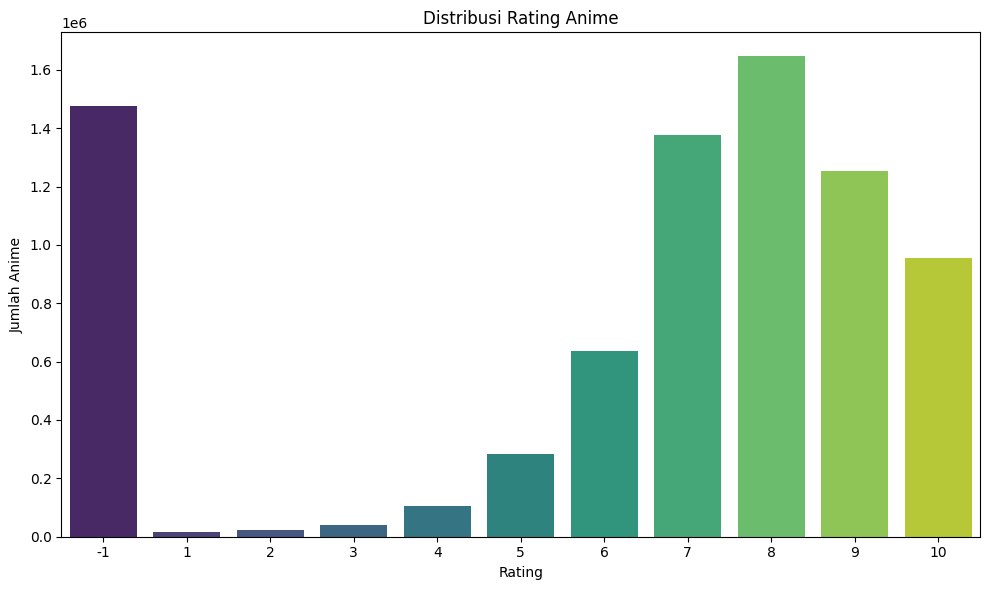

In [14]:
ratings_count = rating_df['rating'].value_counts().sort_index()

plt.figure(figsize=(10,6))
sns.barplot(x=ratings_count.index, y=ratings_count.values, palette='viridis')
plt.title("Distribusi Rating Anime")
plt.xlabel("Rating")
plt.ylabel("Jumlah Anime")
plt.tight_layout()
plt.show()

Dari grafik diatas, terlihat bahwa user kebanyakan memberikan rating dari rentang 7 hingga 10 dengan rating 8 merupakan rating terbanyak yang diberikan oleh user kepada anime-anime yang ada.

### Analisis Genre



Selanjutnya, dilakukan pengecekan jumlah genre yang ada pada setiap anime dengan memisahkan setiap list genre pada anime yang memiliki genre lebih dari satu. Lalu kita juga mengecek apa saja genre-genre yang ada pada **anime_df**

In [15]:
genre_series = anime_df['genre'].dropna().str.split(', ')
genre_list = [genre for sublist in genre_series for genre in sublist]
genre_counts = pd.Series(genre_list).value_counts()

print("Jumlah Genre: ", len(genre_counts))
print("Genre: ", genre_counts.index)

Jumlah Genre:  43
Genre:  Index(['Comedy', 'Action', 'Adventure', 'Fantasy', 'Sci-Fi', 'Drama',
       'Shounen', 'Kids', 'Romance', 'School', 'Slice of Life', 'Hentai',
       'Supernatural', 'Mecha', 'Music', 'Historical', 'Magic', 'Ecchi',
       'Shoujo', 'Seinen', 'Sports', 'Mystery', 'Super Power', 'Military',
       'Parody', 'Space', 'Horror', 'Harem', 'Demons', 'Martial Arts',
       'Dementia', 'Psychological', 'Police', 'Game', 'Samurai', 'Vampire',
       'Thriller', 'Cars', 'Shounen Ai', 'Shoujo Ai', 'Josei', 'Yuri', 'Yaoi'],
      dtype='object')


Dari output kode diatas, terlihat bahwa terdapat 43 genre dari anime-anime pada dataset **anime_df**. Terlihat juga list genre anime tersebut.

Kemudian, dilakukan visualisasi data menggunakan bar chart untuk melihat frekuensi anime dari 43 genre yang ada.

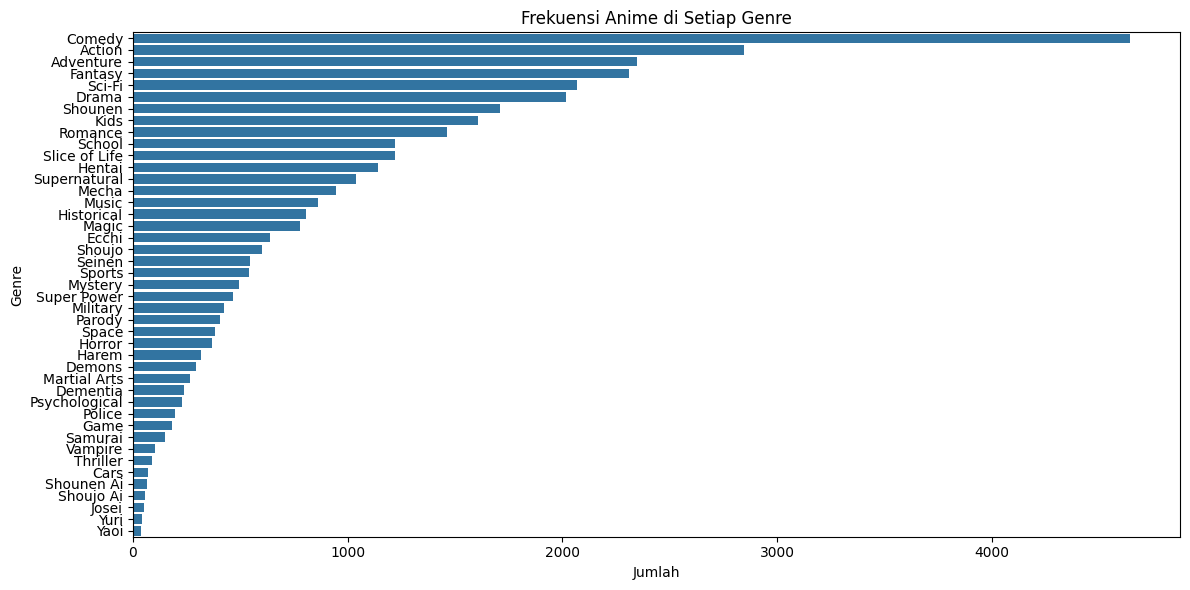

In [16]:
plt.figure(figsize=(12,6))
sns.barplot(x=genre_counts.values, y=genre_counts.index)
plt.title("Frekuensi Anime di Setiap Genre")
plt.xlabel("Jumlah")
plt.ylabel("Genre")
plt.tight_layout()
plt.show()

Dari grafik diatas, dapat dilihat bahwa anime dengan genre Comedy merupakan anime yang paling banyak jumlahnya yaitu lebih dari 4000, kemudian diikuti dengan genre Action dan Adventure. Genre yang paling sedikit jumlah animenya yaitu Yaoi, Yuri, dan Josei.

### Analisis Distribusi Tipe Anime

Pada bagian ini, dilakukan visualisasi menggunakan bar chart untuk menggambarkan distribusi jumlah anime dari variabel `Type` pada **anime_df**.

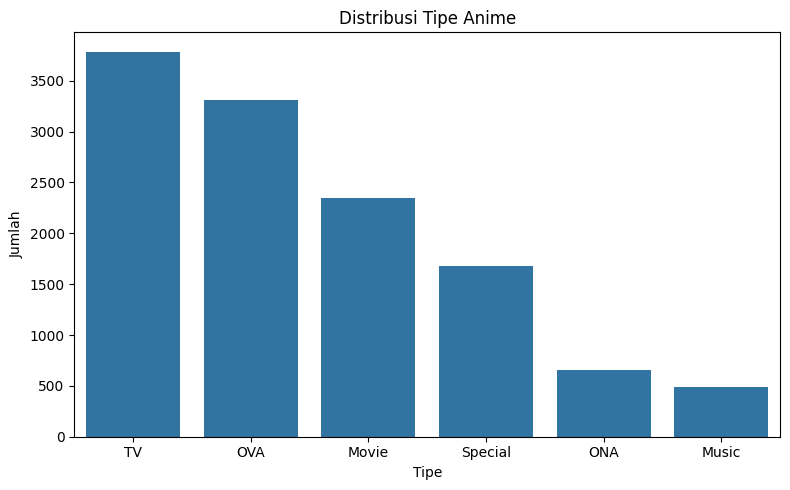

In [17]:
plt.figure(figsize=(8,5))
sns.countplot(data=anime_df, x='type', order=anime_df['type'].value_counts().index)
plt.title("Distribusi Tipe Anime")
plt.xlabel("Tipe")
plt.ylabel("Jumlah")
plt.tight_layout()
plt.show()

Terlihat dari grafik diatas, bahwa tipe anime yang paling dominan adalah TV, dengan jumlah lebih dari 3700 judul. Ini menandakan bahwa format serial televisi merupakan bentuk yang paling umum digunakan dalam industri anime, kemungkinan karena daya tariknya yang tinggi dalam membangun cerita panjang dan basis penggemar yang stabil. Di posisi kedua dan ketiga terdapat tipe OVA (Original Video Animation) dan Movie, masing-masing dengan jumlah sekitar 3300 dan 2300 judul. Secara keseluruhan, grafik ini memberikan gambaran bahwa produksi anime masih sangat didominasi oleh format TV, sementara tipe-tipe lain berperan sebagai pelengkap atau variasi distribusi konten.

# Data Preparation

Ditahap ini, kita melakukan persiapan terhadap data supaya memiliki bentuk yang sesuai untuk digunakan pada model serta hanya fitur-fitur penting saja yang disertakan dalam pelatihan model. Ada beberapa tahap persiapan data yang dilakukan:
1. Menangani Missing Value (Nilai Kosong)
2. Menangani Duplikasi Data
3. Melakukan Penggabungan Data
4. Menghapus Fitur yang tidak dibutuhkan
5. Mengganti Nama Kolom

## Menangani Missing Value (Nilai Kosong)

Ditahap ini, dilakukan penanganan terhadap missing value yang terdapat pada **anime_df** dan **rating_df** dengan melakukan penghapusan terhadap missing value tersebut.

Kode dibawah menunjukkan ukuran dataset sebelum dilakukan penghapusan null value pada dataset **anime_df** dan setelah dilakukan penghapusan tersebut.

In [18]:
print("Jumlah missing value dalam setiap kolom:")
print(anime_df.isnull().sum())
print("\nUkuran dataset anime: ", anime_df.shape)

anime_df.dropna(inplace=True)
print("\nSetelah missing value dihapus")
print("Jumlah missing value dalam setiap kolom:")
print(anime_df.isnull().sum())

print("\nUkuran dataset anime: ", anime_df.shape)

Jumlah missing value dalam setiap kolom:
anime_id      0
name          0
genre        62
type         25
episodes      0
rating      230
members       0
dtype: int64

Ukuran dataset anime:  (12294, 7)

Setelah missing value dihapus
Jumlah missing value dalam setiap kolom:
anime_id    0
name        0
genre       0
type        0
episodes    0
rating      0
members     0
dtype: int64

Ukuran dataset anime:  (12017, 7)


Terlihat bahwa ukuran dataset **anime_df** setelah dilakukan penghapusan null value yaitu terdiri dari 12017 baris dan 7 kolom.

Selanjutnya dilakukan pengecekan jumlah null value pada dataset **rating_df**

In [19]:
rating_df.isna().sum()

,0
user_id,0
anime_id,0
rating,0


Dari kode diatas, terlihat bahwa tidak terdapat missing value sama sekali pada dataset **rating_df**

Kemudian untuk rating yang bernilai -1 pada dataset **rating_df** akan dihapus karena dianggap sebagai missing value. Rating -1 dianggap sebagai null value karena rating tersebut menunjukkan bahwa pengguna menonton anime tersebut tetapi tidak memberikan penilaian/rating

In [20]:
rating_df = rating_df[rating_df['rating'] != -1]
rating_df

,user_id,anime_id,rating
47,1,8074,10
81,1,11617,10
83,1,11757,10
101,1,15451,10
153,2,11771,10
...,...,...,...
7813732,73515,16512,7
7813733,73515,17187,9
7813734,73515,22145,10
7813735,73516,790,9


Terlihat bahwa setelah dilakukan penghapusan rating bernilai -1, ukuran dataset **rating_df** sekarang adalah 6.337.241 baris dan 3 kolom.

## Menangani Duplikasi Data

Ditahap ini, dilakukan penghapusan terhadap data duplikat pada dataset **anime_df** dan **rating_df**. Pertama-tama dilakukan pengecekan jumlah data duplikat pada dataset **anime_df**

In [21]:
anime_df.duplicated().sum()

np.int64(0)

Dari hasil kode diatas, terlihat bahwa tidak terdapat data duplikat pada dataset **anime_df**

Selanjutnya dilakukan pengecekan jumlah data duplikat pada dataset **rating_df**

In [22]:
print("Jumlah duplikasi data pada rating_df: ", rating_df.duplicated().sum())

Jumlah duplikasi data pada rating_df:  1


Terlihat bahwa terdapat 1 data duplikat pada **rating_df**. Karena jumlah data duplikat hanya bernilai 1, maka data duplikat tersebut akan dihapus

In [23]:
rating_df.drop_duplicates(inplace=True)
print("Jumlah duplikasi data pada rating_df: ", rating_df.duplicated().sum())
rating_df.shape

Jumlah duplikasi data pada rating_df:  0


(6337240, 3)

Setelah data duplikat tersebut dihapus, dilakukan pengecekan ulang terhadap jumlah data duplikat pada **rating_df**. Terlihat bahwa jumlah data yang duplikat sudah tidak ada dan ukuran dataset **rating_df** setelah dihapus data duplikat tersebut adalah 6.337.240 baris data dan 3 kolom.

## Melakukan Penggabungan Data

Disini, dilakukan penggabungan dataset antara **rating_df** dan **anime_df** berdasarkan `anime_id`. Penggabungan dataset ini dilakukan secara inner, yaitu hanya anime_id yang beririsan pada **rating_df** dan **anime_df**

In [24]:
df_ratings_anime = pd.merge(rating_df, anime_df, on='anime_id', how='inner')
df_ratings_anime

,user_id,anime_id,rating_x,name,genre,type,episodes,rating_y,members
0,1,8074,10,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural",TV,12,7.46,535892
1,1,11617,10,High School DxD,"Comedy, Demons, Ecchi, Harem, Romance, School",TV,12,7.70,398660
2,1,11757,10,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance",TV,25,7.83,893100
3,1,15451,10,High School DxD New,"Action, Comedy, Demons, Ecchi, Harem, Romance,...",TV,12,7.87,266657
4,2,11771,10,Kuroko no Basket,"Comedy, School, Shounen, Sports",TV,25,8.46,338315
...,...,...,...,...,...,...,...,...,...
6337140,73515,16512,7,Devil Survivor 2 The Animation,"Action, Demons, Supernatural",TV,13,7.06,101266
6337141,73515,17187,9,Ghost in the Shell: Arise - Border:1 Ghost Pain,"Mecha, Police, Psychological, Sci-Fi",Movie,1,7.64,31747
6337142,73515,22145,10,Kuroshitsuji: Book of Circus,"Comedy, Demons, Fantasy, Historical, Shounen, ...",TV,10,8.37,122895
6337143,73516,790,9,Ergo Proxy,"Mystery, Psychological, Sci-Fi",TV,23,8.03,265005


## Menghapus Fitur yang tidak dibutuhkan

Ditahap ini, dilakukan penghapusan fitur yang tidak dipakai untuk pelatihan model kita yaitu `type`, `episodes`, `rating_y`, `members`. Penghapusan fitur ini dilakukan dengan menggunakan method drop.

In [25]:
df_ratings_anime.drop(['type', 'episodes', 'rating_y', 'members'], inplace=True, axis=1)
df_ratings_anime

,user_id,anime_id,rating_x,name,genre
0,1,8074,10,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural"
1,1,11617,10,High School DxD,"Comedy, Demons, Ecchi, Harem, Romance, School"
2,1,11757,10,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance"
3,1,15451,10,High School DxD New,"Action, Comedy, Demons, Ecchi, Harem, Romance,..."
4,2,11771,10,Kuroko no Basket,"Comedy, School, Shounen, Sports"
...,...,...,...,...,...
6337140,73515,16512,7,Devil Survivor 2 The Animation,"Action, Demons, Supernatural"
6337141,73515,17187,9,Ghost in the Shell: Arise - Border:1 Ghost Pain,"Mecha, Police, Psychological, Sci-Fi"
6337142,73515,22145,10,Kuroshitsuji: Book of Circus,"Comedy, Demons, Fantasy, Historical, Shounen, ..."
6337143,73516,790,9,Ergo Proxy,"Mystery, Psychological, Sci-Fi"


## Mengganti Nama Kolom

Selanjutnya dilakukan penggantian nama kolom `rating_x` menjadi `rating` supaya memudahkan interpretasi dan pemanggilan kolom.

In [26]:
df_ratings_anime.rename(columns={'rating_x': 'rating'}, inplace=True)
df_ratings_anime

,user_id,anime_id,rating,name,genre
0,1,8074,10,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural"
1,1,11617,10,High School DxD,"Comedy, Demons, Ecchi, Harem, Romance, School"
2,1,11757,10,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance"
3,1,15451,10,High School DxD New,"Action, Comedy, Demons, Ecchi, Harem, Romance,..."
4,2,11771,10,Kuroko no Basket,"Comedy, School, Shounen, Sports"
...,...,...,...,...,...
6337140,73515,16512,7,Devil Survivor 2 The Animation,"Action, Demons, Supernatural"
6337141,73515,17187,9,Ghost in the Shell: Arise - Border:1 Ghost Pain,"Mecha, Police, Psychological, Sci-Fi"
6337142,73515,22145,10,Kuroshitsuji: Book of Circus,"Comedy, Demons, Fantasy, Historical, Shounen, ..."
6337143,73516,790,9,Ergo Proxy,"Mystery, Psychological, Sci-Fi"


# Content Based Filtering

Content-based filtering adalah metode dalam sistem rekomendasi yang memberikan rekomendasi item kepada pengguna berdasarkan kemiripan karakteristik item dengan item yang disukai atau dinilai tinggi oleh pengguna tersebut sebelumnya

## Data Preparation

Ditahap ini, ada beberapa tahap persiapan data yang dilakukan, yaitu:
1. Menghapus Data anime_id yang Duplikat
2. Pembuatan Matriks TF-IDF

### Menghapus Data anime_id yang Duplikat

Pertama-tama, dataframe yang dibuat sebelumnya dicopy terlebih dahulu ke sebuah variabel baru bernama **anime**

In [27]:
anime = df_ratings_anime.copy()
anime.sort_values('anime_id')

,user_id,anime_id,rating,name,genre
42569,563,1,8,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space"
3083094,35565,1,8,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space"
82177,1051,1,10,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space"
788347,8871,1,10,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space"
5236777,59660,1,7,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space"
...,...,...,...,...,...
2688792,30565,34367,6,Long Riders Recap,"Comedy, Shounen, Slice of Life, Sports"
5481093,62402,34367,4,Long Riders Recap,"Comedy, Shounen, Slice of Life, Sports"
4611461,53492,34475,5,Monster Strike: Rain of Memories,"Action, Fantasy, Game"
1185437,13954,34475,6,Monster Strike: Rain of Memories,"Action, Fantasy, Game"


Ditahap ini, hanya `anime_id` unik yang akan digunakan pada proses pemodelan. Oleh karena itu, dilakukan penghapusan data `anime_id` yang duplikat dengan fungsi drop_duplicates().

In [28]:
anime = anime.drop_duplicates('anime_id')
anime

,user_id,anime_id,rating,name,genre
0,1,8074,10,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural"
1,1,11617,10,High School DxD,"Comedy, Demons, Ecchi, Harem, Romance, School"
2,1,11757,10,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance"
3,1,15451,10,High School DxD New,"Action, Comedy, Demons, Ecchi, Harem, Romance,..."
4,2,11771,10,Kuroko no Basket,"Comedy, School, Shounen, Sports"
...,...,...,...,...,...
6070202,69964,23585,7,Haha wo Tazunete Sanzenri Specials,"Adventure, Drama, Slice of Life"
6070458,69964,33659,6,Fushigi na Somera-chan Special,"Comedy, Magic, Slice of Life"
6274560,72800,30738,4,Gamba: Gamba to Nakama-tachi,"Adventure, Kids"
6300829,73135,8723,5,Anime Rakugo Kan,Comedy


### Pembuatan Matriks TF-IDF

Pertama-tama, dilakukan konversi data series menjadi list menggunakan fungsi tolist() dari library numpy. Data-data ini adalah data yang akan digunakan untuk pemodelan Content Based Filtering yaitu data `anime_id`, `name`, dan `genre`.

In [29]:
anime_id = anime['anime_id'].tolist()
anime_name = anime['name'].tolist()
anime_genres = anime['genre'].tolist()

print(len(anime_id))
print(len(anime_name))
print(len(anime_genres))

9892
9892
9892


Selanjutnya, dibuat dictionary untuk menentukan pasangan key-value pada data anime_id, anime_name, dan anime_genres yang telah disiapkan sebelumnya. Dictionary tersebut kemudian diubah menjadi sebuah dataframe bernama **anime_new**

In [30]:
anime_new = pd.DataFrame({'anime_id': anime_id, 'name': anime_name, 'genre': anime_genres})
anime_new

,anime_id,name,genre
0,8074,Highschool of the Dead,"Action, Ecchi, Horror, Supernatural"
1,11617,High School DxD,"Comedy, Demons, Ecchi, Harem, Romance, School"
2,11757,Sword Art Online,"Action, Adventure, Fantasy, Game, Romance"
3,15451,High School DxD New,"Action, Comedy, Demons, Ecchi, Harem, Romance,..."
4,11771,Kuroko no Basket,"Comedy, School, Shounen, Sports"
...,...,...,...
9887,23585,Haha wo Tazunete Sanzenri Specials,"Adventure, Drama, Slice of Life"
9888,33659,Fushigi na Somera-chan Special,"Comedy, Magic, Slice of Life"
9889,30738,Gamba: Gamba to Nakama-tachi,"Adventure, Kids"
9890,8723,Anime Rakugo Kan,Comedy


Selanjutnya dilakukan penghapusan spasi setelah koma pada kolom genre sehingga dapat mempermudah proses ekstraksi fitur menggunakan tf-idf. Kodenya adalah sebagai berikut:

In [31]:
anime_new['genre'] = anime_new['genre'].apply(lambda x: ','.join(g.strip() for g in x.split(',')) if pd.notna(x) else '')

Kemudian, akan digunakan TF-IDF Vectorizer untuk menemukan representasi fitur penting dari setiap genre anime. Penerapannya dilakukan dengan menggunakan fungsi tfidfvectorizer() dari library sklearn. Selanjutnya tfidf di fit menggunakan data kolom genre dan ditampilkan semua nama fitur pada tfidf tersebut.

In [32]:
tfidf = TfidfVectorizer(token_pattern=r'[^,]+')
tfidf.fit(anime_new['genre'])
tfidf.get_feature_names_out()

array(['action', 'adventure', 'cars', 'comedy', 'dementia', 'demons',
       'drama', 'ecchi', 'fantasy', 'game', 'harem', 'hentai',
       'historical', 'horror', 'josei', 'kids', 'magic', 'martial arts',
       'mecha', 'military', 'music', 'mystery', 'parody', 'police',
       'psychological', 'romance', 'samurai', 'school', 'sci-fi',
       'seinen', 'shoujo', 'shoujo ai', 'shounen', 'shounen ai',
       'slice of life', 'space', 'sports', 'super power', 'supernatural',
       'thriller', 'vampire', 'yaoi', 'yuri'], dtype=object)

Selanjutnya, dilakukan fit dan transformasi tfidf ke dalam bentuk matriks.

In [33]:
tfidf_matrix = tfidf.fit_transform(anime_new['genre'])
tfidf_matrix.shape

(9892, 43)

Dapat dilihat dari output kode tersebut bahwa matriks dari tfidf berukuran (9892, 43). Nilai 9892 merupakan ukuran data dan 43 merupakan ukuran genre anime.

Untuk menghasilkan vektor tf-idf dalam bentuk matriks, digunakan fungsi todense(). Kodenya sebagai berikut.

In [ ]:
tfidf_matrix.todense()

matrix([[0.33234792, 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.31886448, 0.35205705, 0.        , ..., 0.        , 0.        ,
         0.        ],
        ...,
        [0.        , 0.59594573, 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ],
        [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
         0.        ]])

## Modelling

Ditahap ini, dilakukan penghitungan derajat kesamaan (similarity degree) antar anime dengan teknik cosine similarity menggunakan fungsi cosine_similarity dari library sklearn.

In [ ]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.22765335, 0.10597395, ..., 0.        , 0.        ,
        0.        ],
       [0.22765335, 1.        , 0.13375583, ..., 0.        , 0.22106054,
        0.22106054],
       [0.10597395, 0.13375583, 1.        , ..., 0.2098069 , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.2098069 , ..., 1.        , 0.        ,
        0.        ],
       [0.        , 0.22106054, 0.        , ..., 0.        , 1.        ,
        1.        ],
       [0.        , 0.22106054, 0.        , ..., 0.        , 1.        ,
        1.        ]])

Selanjutnya, dibuat sebuah DataFrame yang berisi cosine similarity antara judul anime dengan judul anime lainnya. Kemudian dilihat DataFrame tersebut dalam 5 sampel kolom dan 10 sampel baris.

In [ ]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=anime_new['name'], columns=anime_new['name'])
print('Shape:', cosine_sim_df.shape)

cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (9892, 9892)


name,Tokyo Ghoul,Bakuon!!,Peeping Life,Damekko Doubutsu,Ao no Exorcist Movie
name,,,,,
Kono Aozora ni Yakusoku wo: Youkoso Tsugumi Ryou e,0.000000,0.000000,0.000000,0.000000,0.000000
Bokusatsu Tenshi Dokuro-chan,0.000000,0.122681,0.177337,0.348303,0.000000
Ashita Tenki ni Naare,0.000000,0.000000,0.000000,0.000000,0.000000
Odin: Koushi Hansen Starlight,0.255983,0.000000,0.000000,0.000000,0.146694
Mashou no Nie 3,0.000000,0.000000,0.000000,0.000000,0.000000
Kitty-chan wo Sagase! Toyama-shi Stamp Rally,0.000000,0.352226,0.509146,1.000000,0.000000
Jie Mo Ren,0.525439,0.000000,0.000000,0.000000,0.516079
Senkou no Night Raid Picture Drama,0.091026,0.000000,0.000000,0.000000,0.124565
Yu-No,0.000000,0.000000,0.000000,0.000000,0.000000


Kemudian, dibuat fungsi rekomendasi anime berdasarkan kemiripan dari genre dengan keluaran fungsi berupa top-N recommendation yang nilai N-nya diatur dalam parameter k.

In [ ]:
def anime_recommendations(nama_anime, similarity_data=cosine_sim_df, items=anime_new[['name', 'genre']], k=10):
    index = similarity_data.loc[:,nama_anime].to_numpy().argpartition(range(-1, -k, -1))
    closest = similarity_data.columns[index[-1:-(k+2):-1]]
    closest = closest.drop(nama_anime, errors='ignore')
    return pd.DataFrame(closest).merge(items).head(k)

Ditahap ini, dilakukan pengetesan fungsi rekomendasi yang telah dibuat menggunakan sebuah anime bernama 'Shingeki no Kyojin' untuk menghasilkan 10 rekomendasi anime baru.

In [ ]:
anime_new[anime_new.name.eq('Shingeki no Kyojin')]

,anime_id,name,genre
55,16498,Shingeki no Kyojin,"Action,Drama,Fantasy,Shounen,Super Power"


Selanjutnya, kita menyimpan 10 rekomendasi anime baru yang sama dengan 'Shingeki no Kyojin' di variabel `recs`

In [ ]:
recs = anime_recommendations('Shingeki no Kyojin')
recs

,name,genre
0,Shingeki no Kyojin: Ano Hi Kara,"Action,Drama,Fantasy,Shounen,Super Power"
1,Shingeki no Kyojin Movie 2: Jiyuu no Tsubasa,"Action,Drama,Fantasy,Shounen,Super Power"
2,Shingeki no Kyojin Movie 1: Guren no Yumiya,"Action,Drama,Fantasy,Shounen,Super Power"
3,Shingeki no Kyojin OVA,"Action,Drama,Fantasy,Shounen,Super Power"
4,Saint Seiya: Meiou Hades Elysion-hen,"Action,Fantasy,Shounen,Super Power"
5,One Piece: Episode of Merry - Mou Hitori no Na...,"Action,Adventure,Comedy,Drama,Fantasy,Shounen,..."
6,One Piece: Episode of Sabo - 3 Kyoudai no Kizu...,"Action,Adventure,Comedy,Drama,Fantasy,Shounen,..."
7,One Piece: Episode of Nami - Koukaishi no Nami...,"Action,Adventure,Comedy,Drama,Fantasy,Shounen,..."
8,One Piece: Romance Dawn Story,"Action,Comedy,Fantasy,Shounen,Super Power"
9,Kouryuu no Mimi: Mina no Shou,"Action,Drama,Super Power"


## Evaluation

Ditahap ini, dibuat sebuah fungsi untuk menghitung nilai metriks Precision pada sistem rekomendasi, dimana akan dihitung jumlah anime yang genrenya relevan dengan jumlah anime yang direkomendasikan.

In [ ]:
def precision_at_k(query_anime_name, recommendations, anime_data):
    # Ambil genre anime acuan
    query_genres = anime_data[anime_data['name'] == query_anime_name]['genre'].values[0]
    query_genres_set = set(query_genres.lower().split(','))

    # Hitung relevansi setiap anime rekomendasi
    relevant_count = 0
    for genre_str in recommendations['genre']:
        rec_genres_set = set(genre_str.lower().split(','))
        if query_genres_set & rec_genres_set:  # set intersection tidak kosong
            relevant_count += 1

    # Precision = relevan / total rekomendasi
    precision = relevant_count / len(recommendations)
    return precision
precision = precision_at_k('Shingeki no Kyojin', recs, anime_new)
print(f'Precision: {precision:.2f}')

Precision: 1.00


Dari output kode diatas, didapat hasil metriks precision berupa 1.00. Ini berarti semua anime yang direkomendasikan memiliki setidaknya satu genre yang sama dengan yang dimiliki oleh anime 'Shingeki no Kyojin'

# Collaborative Filtering

Model-Based Deep Learning Collaborative Filtering adalah pendekatan yang menggabungkan teknik collaborative filtering dengan metode deep learning untuk meningkatkan akurasi dan efektivitas sistem rekomendasi.

## Data Preparation

Ditahap ini, ada beberapa tahap persiapan data yang dilakukan, yaitu:
- Menghapus Kolom yang Tidak Dibutuhkan
- Encoding user_id dan anime_id
- Membagi Data untuk Training dan Validasi

### Menghapus Kolom yang Tidak Dibutuhkan

Ditahap ini, hanya data kolom `user_id`, `anime_id`, dan `rating` saja yang dibutuhkan dalam tahap pemodelan, sehingga kolom `name` dan `genre` dihapus dengan menggunakan fungsi drop().

In [34]:
anime_ratings = df_ratings_anime.copy()
anime_ratings.drop(['name', 'genre'], axis=1, inplace=True)
anime_ratings

,user_id,anime_id,rating
0,1,8074,10
1,1,11617,10
2,1,11757,10
3,1,15451,10
4,2,11771,10
...,...,...,...
6337140,73515,16512,7
6337141,73515,17187,9
6337142,73515,22145,10
6337143,73516,790,9


### Encoding user_id dan anime_id

Pertama, dilakukan encoding terhadap user_id

In [35]:
user_ids = anime_ratings['user_id'].unique().tolist()
user_to_user_encoded = {x: i for i, x in enumerate(user_ids)}
user_encoded_to_user = {i: x for i, x in enumerate(user_ids)}

Selanjutnya, dilakukan encoding juga terhadap anime_id

In [36]:
anime_ids = anime_ratings['anime_id'].unique().tolist()
anime_to_anime_encoded = {x: i for i, x in enumerate(anime_ids)}
anime_encoded_to_anime = {i: x for i, x in enumerate(anime_ids)}

Setelah itu, user_id dan anime_id dipetakan ke dataframe yang berkaitan

In [37]:
# Mapping userID ke dataframe user
anime_ratings['user'] = anime_ratings['user_id'].map(user_to_user_encoded)

# Mapping placeID ke dataframe anime
anime_ratings['anime'] = anime_ratings['anime_id'].map(anime_to_anime_encoded)

Terakhir, dilakukan pengecekan beberapa hal dalam data seperti jumlah user, jumlah anime, dan kemudian mengubah nilai rating menjadi float. Dilakukan juga pengecekan terhadap rating minimum dan rating maksimum

In [38]:
# Mendapatkan jumlah user
num_users = len(user_to_user_encoded)
print(num_users)

# Mendapatkan jumlah anime
num_anime = len(anime_encoded_to_anime)
print(num_anime)

# Mengubah rating menjadi nilai float
anime_ratings['rating'] = anime_ratings['rating'].values.astype(np.float32)

# Nilai minimum rating
min_rating = min(anime_ratings['rating'])

# Nilai maksimal rating
max_rating = max(anime_ratings['rating'])

print('Number of User: {}, Number of Anime: {}, Min Rating: {}, Max Rating: {}'.format(
    num_users, num_anime, min_rating, max_rating
))

69600
9892
Number of User: 69600, Number of Anime: 9892, Min Rating: 1.0, Max Rating: 10.0


Dari output kode diatas, dapat dilihat bahwa jumlah user: 69600, jumlah anime: 9892, rating minimum: 1.0, dan rating maksimum: 10.0

### Membagi Data untuk Training dan Validasi

Ditahap ini, dilakukan pembagian data training dan data validasi untuk proses pelatihan model. Pertama-tama, dilakukan pengacakan data supaya distribusinya menjadi acak.

In [ ]:
anime_ratings = anime_ratings.sample(frac=1, random_state=42)
anime_ratings

,user_id,anime_id,rating,user,anime
2393662,27383,1557,6.0,25904,2471
490859,5899,12365,6.0,5566,777
2730967,31017,157,7.0,29339,2165
4567340,53005,205,10.0,50155,121
2250913,25989,10721,9.0,24584,1378
...,...,...,...,...,...
1570006,18815,10521,8.0,17767,312
2234489,25833,469,9.0,24439,1085
4926484,57108,19369,6.0,54062,432
4304572,50462,1117,6.0,47717,171


Selanjutnya, data train dan validasi dibagi engan komposisi 80:20. Namun sebelumnya, dilakukan pemetaan (mapping) data user dan anime menjadi satu value terlebih dahulu yaitu x. Lalu, dibuat rating dalam skala 0 sampai 1 agar mudah dalam melakukan proses training dan disimpan pada variabel y.

In [ ]:
x = anime_ratings[['user', 'anime']].values
y = anime_ratings['rating'].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values

# Membagi menjadi 80% data train dan 20% data validasi
train_indices = int(0.8 * anime_ratings.shape[0])
x_train, x_val, y_train, y_val = (
    x[:train_indices],
    x[train_indices:],
    y[:train_indices],
    y[train_indices:]
)

print(f'Ukuran dataset: {x.shape}')
print(f'Ukuran data train: {x_train.shape}')
print(f'Ukuran data validasi: {x_val.shape}')

Ukuran dataset: (6337145, 2)
Ukuran data train: (5069716, 2)
Ukuran data validasi: (1267429, 2)


## Modelling

Ditahap ini, dibuat sebuah class RecommenderNet dengan keras Model class. Class ini merupakan model yang akan menghitung skor kecocokan antara pengguna dan anime dengan teknik embedding. Pertama, dilakukan proses embedding terhadap data user dan anime. Selanjutnya, dilakukan operasi perkalian dot product antara embedding user dan anime. Lalu, ditambahkan dropout untuk mengurangi overfitting. Selain itu, ditambahkan juga bias untuk setiap user dan anime. Skor kecocokan ditetapkan dalam skala [0,1] dengan fungsi aktivasi sigmoid.



In [ ]:
class RecommenderNet(tf.keras.Model):
  def __init__(self, num_users, num_anime, embedding_size, **kwargs):
    super(RecommenderNet, self).__init__(**kwargs)
    self.num_users = num_users
    self.num_anime = num_anime
    self.embedding_size = embedding_size
    self.user_embedding = layers.Embedding(
        num_users,
        embedding_size,
        embeddings_initializer = 'uniform',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.user_bias = layers.Embedding(num_users, 1)
    self.anime_embedding = layers.Embedding(
        num_anime,
        embedding_size,
        embeddings_initializer = 'uniform',
        embeddings_regularizer = keras.regularizers.l2(1e-6)
    )
    self.anime_bias = layers.Embedding(num_anime, 1)
    self.dropout = layers.Dropout(0.3)

  def call(self, inputs):
    user_vector = self.user_embedding(inputs[:,0])
    user_bias = self.user_bias(inputs[:, 0])
    anime_vector = self.anime_embedding(inputs[:, 1])
    anime_bias = self.anime_bias(inputs[:, 1])

    dot_user_anime = tf.tensordot(user_vector, anime_vector, 2)
    dot_user_anime = self.dropout(dot_user_anime)

    x = dot_user_anime + user_bias + anime_bias

    return tf.nn.sigmoid(x)

Selanjutnya, dilakukan proses compile terhadap model. Model menggunakan Mean Squared Error untuk menghitung loss function, RMSprop sebagai optimizer, dan root mean squared error (RMSE) sebagai metrics evaluation.

In [ ]:
model = RecommenderNet(num_users, num_anime, 10) # inisialisasi model

# model compile
model.compile(
    loss = tf.keras.losses.MeanSquaredError(),
    optimizer = keras.optimizers.RMSprop(learning_rate=0.001),
    metrics=[tf.keras.metrics.RootMeanSquaredError()]
)

Selanjutnya dilakukan proses training dengan method fit

In [ ]:
history = model.fit(
    x = x_train,
    y = y_train,
    batch_size = 512,
    epochs = 10,
    validation_data = (x_val, y_val)
)

Epoch 1/10
9902/9902 ━━━━━━━━━━━━━━━━━━━━ 54s 4ms/step - loss: 0.0430 - root_mean_squared_error: 0.2028 - val_loss: 0.0261 - val_root_mean_squared_error: 0.1594
Epoch 2/10
9902/9902 ━━━━━━━━━━━━━━━━━━━━ 59s 3ms/step - loss: 0.0255 - root_mean_squared_error: 0.1576 - val_loss: 0.0245 - val_root_mean_squared_error: 0.1546
Epoch 3/10
9902/9902 ━━━━━━━━━━━━━━━━━━━━ 42s 3ms/step - loss: 0.0241 - root_mean_squared_error: 0.1533 - val_loss: 0.0235 - val_root_mean_squared_error: 0.1516
Epoch 4/10
9902/9902 ━━━━━━━━━━━━━━━━━━━━ 31s 3ms/step - loss: 0.0231 - root_mean_squared_error: 0.1505 - val_loss: 0.0227 - val_root_mean_squared_error: 0.1493
Epoch 5/10
9902/9902 ━━━━━━━━━━━━━━━━━━━━ 30s 3ms/step - loss: 0.0224 - root_mean_squared_error: 0.1482 - val_loss: 0.0221 - val_root_mean_squared_error: 0.1475
Epoch 6/10
9902/9902 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - loss: 0.0219 - root_mean_squared_error: 0.1466 - val_loss: 0.0217 - val_root_mean_squared_error: 0.1460
Epoch 7/10
9902/9902 ━━━━━━━━━━━━━

Dapat dilihat dari output diatas, model memperoleh nilai root_mean_squared_error: 0.1420 untuk data latih dan 0.1422 untuk data validasi

Selanjutnya, dilakukan pengetesan model untuk mendapatkan rekomendasi resto. Pertama, diambil sampel user secara acak dan definisikan variabel anime_not_watched yang merupakan daftar anime yang belum pernah dinonton oleh pengguna. Sebelumnya, pengguna telah memberi rating pada beberapa animeyang telah mereka nonton. Rating ini akan digunakan untuk membuat rekomendasi anime yang mungkin cocok untuk pengguna.

In [ ]:
animes_df = anime_new
df = pd.read_csv('rating.csv')

user_id = df.user_id.sample(1).iloc[0]
anime_watched_by_user = df[df.user_id == user_id]

anime_not_watched = animes_df[~animes_df['anime_id'].isin(anime_watched_by_user.anime_id.values)]['anime_id']
anime_not_watched = list(
    set(anime_not_watched)
    .intersection(set(anime_to_anime_encoded.keys()))
)

anime_not_watched = [[anime_to_anime_encoded.get(x)] for x in anime_not_watched]
user_encoder = user_to_user_encoded.get(user_id)
user_anime_array = np.hstack(
    ([[user_encoder]] * len(anime_not_watched), anime_not_watched)
)

Selanjutnya, untuk memperoleh rekomendasi anime, digunakan fungsi model.predict() dari library Keras dengan menerapkan kode berikut.

In [ ]:
ratings = model.predict(user_anime_array).flatten()

top_ratings_indices = ratings.argsort()[-10:][::-1]
recommended_anime_ids = [
    anime_encoded_to_anime.get(anime_not_watched[x][0]) for x in top_ratings_indices
]

print('Showing Anime Recommendations For User: {}'.format(user_id))
print('===' * 9)
print('Anime with high ratings from user')
print('----' * 8)

top_anime_user = (
    anime_watched_by_user.sort_values(
        by = 'rating',
        ascending=False
    )
    .head(5)
    .anime_id.values
)

anime_df_rows = animes_df[animes_df['anime_id'].isin(top_anime_user)]
for row in anime_df_rows.itertuples():
    print(row.name, ':', row.genre)

print('----' * 8)
print('Top 10 Anime Recommendations')
print('----' * 8)

i = 1
recommended_anime = animes_df[animes_df['anime_id'].isin(recommended_anime_ids)]
for row in recommended_anime.itertuples():
    print(i, ". ", row.name)
    print("   Genre: ", row.genre)
    i += 1

305/305 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
Showing Anime Recommendations For User: 67180
Anime with high ratings from user
--------------------------------
Neon Genesis Evangelion : Action,Dementia,Drama,Mecha,Psychological,Sci-Fi
Neon Genesis Evangelion: Death &amp; Rebirth : Drama,Mecha,Psychological,Sci-Fi
Neon Genesis Evangelion: The End of Evangelion : Dementia,Drama,Mecha,Psychological,Sci-Fi
Rurouni Kenshin: Meiji Kenkaku Romantan - Tsuioku-hen : Action,Drama,Historical,Martial Arts,Romance,Samurai
Mononoke Hime : Action,Adventure,Fantasy
--------------------------------
Top 10 Anime Recommendations
--------------------------------
1 .  Fullmetal Alchemist: Brotherhood
   Genre:  Action,Adventure,Drama,Fantasy,Magic,Military,Shounen
2 .  Gintama
   Genre:  Action,Comedy,Historical,Parody,Samurai,Sci-Fi,Shounen
3 .  Steins;Gate
   Genre:  Sci-Fi,Thriller
4 .  Gintama&#039;
   Genre:  Action,Comedy,Historical,Parody,Samurai,Sci-Fi,Shounen
5 .  Gintama Movie: Kanketsu-hen - Yorozuya 

## Evaluation

Ditahap evaluasi, dilakukan visualisasi metrik
evaluasi yaitu Root Mean Squared Error (RMSE) menggunakan plot garis untuk menunjukkan perubahan RMSE pada setiap epochs.

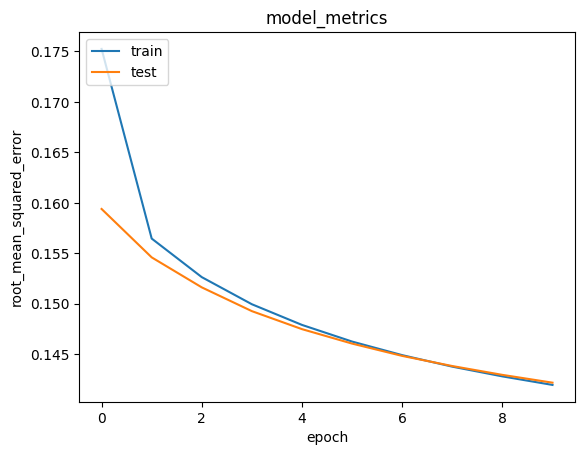

In [ ]:
plt.plot(history.history['root_mean_squared_error'])
plt.plot(history.history['val_root_mean_squared_error'])
plt.title('model_metrics')
plt.ylabel('root_mean_squared_error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

Berdasarkan grafik tersebut, dapat dilihat bahwa nilai error akhir untuk data training sebesar 0.1420 dan error pada data validase sebesar 0.1422. Nilai tersebut cukup bagus untuk sistem rekomendasi.